# Define all imports

In [13]:
import string
import nltk
from nltk import word_tokenize, FreqDist, tokenize
from nltk.corpus import stopwords
from xlrd import open_workbook
import re

import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import pandas as pd

import enchant
d = enchant.Dict("en_US")
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [332]:
newstopwords=stopwords.words("English")
newstopwords=newstopwords+['january','february','march','april','may','june','july','august','september','october','november','december']
newstopwords=newstopwords+['employee','employer','company','approximately','work','right','leave','worker','coworker','catch','back']
newstopwords=newstopwords+['one','two','three','four','five','six','number']
newstopwords=newstopwords+['kill','hospitalization','heart','attack','finger','foot','abdomen','hand','injure','injury','amputate','head','fracture','suffer','cause','treat','treatment','hospital','hospitalize']
newstopwords=newstopwords+['investigation','coworkers','inside','another','area','place','onto','accident','become','part','line','side','break','pull','build','central','inside','time']
WNlemma = nltk.WordNetLemmatizer()

def pre_process(text):
    text=str(text)
    #print(len(text))
    #if not text.isdigit():
    tokens=nltk.word_tokenize(text)
        #print(tokens)
    tokens=[ t.lower() for t in tokens if t not in string.punctuation ]
    tokens=[ WNlemma.lemmatize(t.lower(),pos='v') for t in tokens]
    tokens=[ WNlemma.lemmatize(t.lower(),pos='n') for t in tokens]
    tokens=[ t for t in tokens if t not in newstopwords]
    tokens = [ t for t in tokens if len(t) > 3 ]
    tokens = [word1 for word1 in tokens if not re.search(r'\b\w*\d+\W*\b', word1)] #remove words with digits
    tokens = [word2 for word2 in tokens if not re.search(r'\w*\.+', word2)] #remove words with full stop
    tokens = [word3 for word3 in tokens if d.check(word3)] #remove none english word
    try:
        #print(tokens)
        tokens = [word4[0] for word4 in nltk.pos_tag(tokens) if word4[1]!='VB' ] #get none verb
        #print(tokens)
        text_after_process=" ".join(tokens)
    except:
        print('not working')
        text_after_process=tokens
    return(text_after_process)

def get_freq(text):    
    test=''
    for sublist in text: 
        test=test + ' ' + sublist
    words = nltk.tokenize.word_tokenize(test)
    fdist = FreqDist(words)
    return fdist

def get_Bigram(text):    
    from nltk.corpus import stopwords
    from nltk.collocations import BigramCollocationFinder
    from nltk.metrics import BigramAssocMeasures
   
    test=''
    for sublist in text: 
        test=test + ' ' + sublist
    words = nltk.tokenize.word_tokenize(test)
    bcf = BigramCollocationFinder.from_words(words)
    for m in bcf.nbest(BigramAssocMeasures.likelihood_ratio, 50):
        bigram_result=print(nltk.tag.pos_tag(m))
    return bigram_result

def create_wordcloud(text,title): 
    # We can also generate directly from the frequency information
    wc2 = WordCloud(background_color="white")
    wc2.generate_from_frequencies(text)
    plt.imshow(wc2, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def get_occupation(text):
    text=str(text)
    sentence_tokenize = sent_tokenize(text)
    
    try:
        searchObj = re.search( r'\(*Employee\)* #1 a (\w+\s\w+\b)', sentence_tokenize[0], re.M|re.I) #extract occupation name
        tokens=nltk.word_tokenize(searchObj.group(1))
        post_tag=nltk.pos_tag(tokens)
        if post_tag[1][1] != 'VBD' and post_tag[1][1] != 'IN':
            #print(searchObj.group(1))
            return (searchObj.group(1))
        else:
            #print(post_tag[0][0])
            return(post_tag[0][0])
    except:
        pass

def get_action(text):
    text=str(text)
    sentence_tokenize = sent_tokenize(text.lower())

    try:
        searchObj = re.search( r'(was|were) (\D*\s*?)', sentence_tokenize[0], re.M|re.I) #extract occupation name
        
        #lemmatize
        tokens=nltk.word_tokenize(searchObj.group(2))
        tokens=[ t.lower() for t in tokens if t not in string.punctuation ]
        tokens=[ WNlemma.lemmatize(t,pos='v') for t in tokens]
        tokens=[ WNlemma.lemmatize(t,pos='n') for t in tokens]
        tokens=[ t for t in tokens if t not in newstopwords]
        #print(" ".join(tokens))
        return " ".join(tokens)
    except:
        return text.lower()
        #pass

# Arrange data in table form using Panda (4 columns from osha file with header as Index, Title, Decription, Support1 and Support2)

In [15]:
news=pd.read_excel('osha.xlsx',header=None,names = ["Index", "Title","Description", "Support1","Support2"])
news.head()

,Index,Title,Description,Support1,Support2
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2...,burn industrial truck waste proc fac pa...,
1,202561825,Employee Falls From Flatbed Trailer And Later...,On August 30 2013 Employee #1 was working f...,truck flatbed truck trailer fall abdomen,
2,200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of T...,construction undrgrd power line highway ...,1 317290559 Fatality Other Occupation not re...
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iro...,waste proc fac industrial truck struck b...,
4,201079324,Employee Is Splashed With Hot Water And Is Bu...,On July 14 2013 Employee #1 vacuum pump tr...,truck driver pump tank hot water struc...,


# list down most frequent key words after removing words none related to occupation

In [16]:
# Apply preprocessing to every document in the training set.
decribe = news['Description']
toks_des = decribe.apply(pre_process)

support1 = news['Support1']
toks_support = support1.apply(pre_process)

title = news['Title']
toks_title = title.apply(pre_process)

In [17]:
Description_dist=get_freq(toks_des)
title_dist=get_freq(toks_title)
support1_dist=get_freq(toks_support)

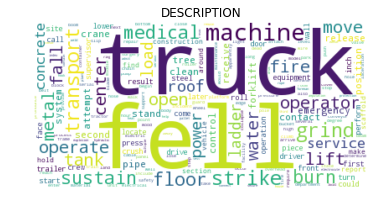

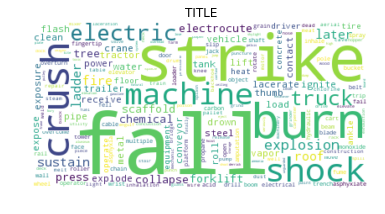

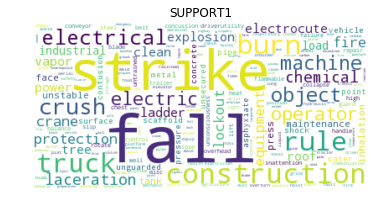

In [18]:
create_wordcloud(Description_dist,"DESCRIPTION")
create_wordcloud(title_dist,"TITLE")
create_wordcloud(support1_dist,"SUPPORT1")

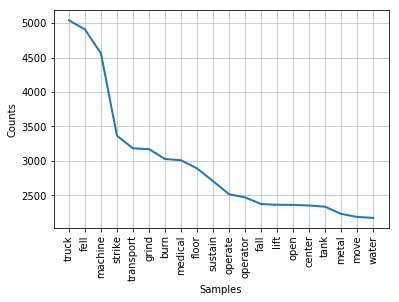

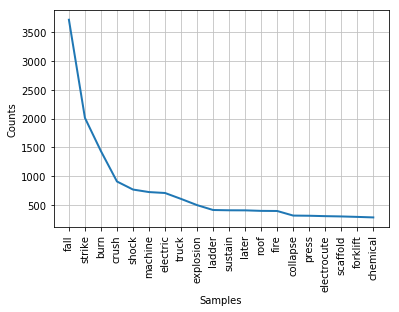

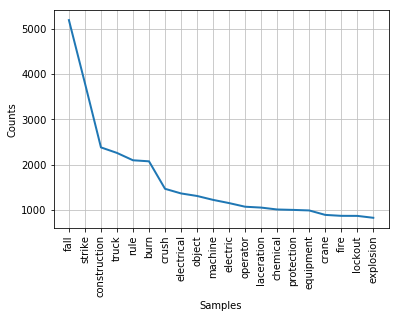

In [19]:
Description_distplot=Description_dist.plot(20)
Title_distplot=title_dist.plot(20)
Support1_distplot=support1_dist.plot(20)

In [20]:
#comments:
#1) fell and fall appear most frequent which related to construction activity
#2) truck also appear most frequent which related to heavy vehicle driver

# Possible list of occupation or work under Description column

In [333]:
likely_occupation = news['Description']
#likelyoccup_des = likely_occupation.apply(get_occupation) #extract words (max 2) right after Employee #1
#possible list of name
count=0
for m in likely_occupation:
    #print(str(count)+":"+str(get_occupation(m)))
    count=count+1

# Extract phrases likely related to work in description column

In [334]:
decribe = news['Description']
toks_des_action = decribe.apply(get_action) # words right after was or were which describe what the person doing at that point in time

# Categories Occupations based on extracting keywords from each case

In [342]:
#the worker title based on heuristic info
occupation_dict=dict({
            'carpenter':['wood','carpentry','carpenter'],
            'chemical worker':['chemical','anhydrous ammonia','oxy-acetylene','container','tank','xylene','burn','acid','acetone'],
            'construction worker':['catwalk','scaffold','safety bar','construct','aerial lift','scissor lift','chimney','tile','ceiling','demolition','pallet','foreman','construction','ladder','contractor','roof','concrete','fell','fall','cement'],
            'electrician':['wire','circuit','electrocute','electric','electronic','power','transformer','volt'],
            'firefighter':['fire','blaze'],        
            'hotel/restaurant worker':['motel','hotel','restaurant'],
            'hospital worker':['medicine','medical'],
            'heavy vehicle driver':['excavator','truck','forklift','tractor','trailer','crane'],
            'light vehicle driver':['vehicle'],
            'machine operator':['machine','tire','vibrator','conveyor','crusher','grind'],
            'shop/office worker':['computer','shop','office','supermarket','receptionist','casher','desk'],
            'wood logger':['yarder','tree','logging'],
            'mower':['grass'],
            'dock worker':['loader','load','terminal','hoist'],
            'painting service':['paint','painting'],
            'cleaner':['wash','sewer tank','odorous','vacuum','tank','water','clean','sanitize'],
            'technician':['equipment','machinery','technician'],
            'mechanic':['maintenance','mechanical'],
            'derrickman':['pipe','drill'],
            'digger':['excavation'],
            'farmer':['agriculture','vineyard','cow','harvest','barn','coccidioides imitis fungus','crop market','peach','fruit','farmer','farm','blackberries','harverst','grape','picker','gardern'],
            'sales worker':['cash','retail','store'],
            'well puller':['oil'],
            'welder':['welding','vapor','gas'],
            'clerk':['clerk','stockroom'],
            'food worker':['food'],
            'road worker':['highway','road','traffic'],
            'blasting worker':['blast'],
            'operator':['operator','production','operating','operation','operate','manufacture','assemble'],
            'laborer':['laborer','labor'],
            'welder':['weld','torch'],
            'hoister':['hoist'],
            'grinder':['grind'],
            'warehouse':['warehouse','storage'],
            'hydraulic pneumatic worker':['gas','hydraulic','pressure','compress','pneumatic','air hammer','pressurize'],
            'fisherman':['sea urchin'],
            'engineer':['engineer'],
            'instructor':['program','instructor'],
            'amusement park worker':['amusement','park'],
            'inmate':['inmate'],
            'machine cutter':['saw','chopper'],
            'trash collector':['trash'],
            'plumber':['hose','plumb','pump'],
            'aerospace':['aircraft','aerospace','airline','airplane','aeroplane','helicopter'],
            'animal worker':['wildlife','feed','zoo','keeper','animal','horse'],
            'police':['police'],
            'telecom':['antenna','phone','cell','cellular','communication','tower'],
            'restoration service':['asbestos'],
            'contractor':['repair','residential','renovation','residence'],
            'nature lifeguard':['storm','hurricane','avalanche','snow','snowmobile'],
            'logistic':['rigger','rig','transport','airport'],
            'factory worker':['factory','industry'],
            'installer':['instal','beam','steel'],
            'guard':['security','guard'],
            'cable guy':['cable'],
            'inspector':['inspection','inspect','inspector'],
            'service guy':['service'],
            'supervisor':['supervisor','supervise']
        })

# Getting the occurance of the occupation based on how frequent each of the keywords appear on each cases

In [350]:
count=np.zeros((len(occupation_dict)), dtype=np.int)
break_flag=False
track_missing=[]
store_occupation_array=[]
#print(toks_des_action)
line_tracking=0
for num in toks_des_action: #screen thru each cases
    
    break_flag=False
    tracking=0 #occupation index. Reset for each looping of case
    #print(num)
    if num!=None:
        for key,value in occupation_dict.items():
            if break_flag==True:
                break
            #print(key)
            for v in value:
                #print(v)
                if num.find(v)>=0: #detected matching. Update the count and move to next case
                    count[tracking]=count[tracking]+1
                    store_occupation_array.append(key)
                    break_flag=True
                    break
            tracking=tracking+1
    if break_flag==False:
        #track_missing.append(num) #track how many cases without occupation identificatinon
        store_occupation_array.append('') #update no occupation identified for this case
    line_tracking=line_tracking+1
    #print(line_tracking)
#len(track_missing) 
print("Total number of cases " + str(len(store_occupation_array)))

Total number of cases 16323


# Redo Occupation identification on Support1 column to try to fill up cases without occupation

In [351]:
break_flag=False
empty_flag=False
track_missing=[]
#store_occupation_array=[]
#print(toks_des_action)
line_tracking=0
for num in news["Support1"]: #screen thru each cases
    
    break_flag=False
    tracking=0 #occupation index. Reset for each looping of case
    #print(num)
    if num!=None:
        for key,value in occupation_dict.items():
            if break_flag==True:
                break
            #print(key)
            for v in value:
                #print(v)
                if num.find(v)>=0: #detected matching. Update the count and move to next case
                    if store_occupation_array[line_tracking]=="": #empty go ahead to update occupation
                        count[tracking]=count[tracking]+1
                        store_occupation_array[line_tracking]=key
                        break_flag=True
                        break
            tracking=tracking+1
    if store_occupation_array[line_tracking]=="":
        track_missing.append(num) #track how many cases without occupation identificatinon
        #store_occupation_array.append('')
    line_tracking=line_tracking+1
    #print(line_tracking)
print("cases unable to identify occupation " + str(len(track_missing))) 
#len(store_occupation_array)

cases unable to identify occupation 372


In [352]:
print(count) #frequency for each occupation

[ 476 1657 3877  947  216   67  100 1748  126 1221  138  224   17  326  100
  640  137  161  246   35  175   90  145  117    2   45  149   29  688   56
    0    0   96  189    5   12   11   59    5   91   14   76   32   67    8
   84   12  219   24  128   13  323   41   25  384   60   18]


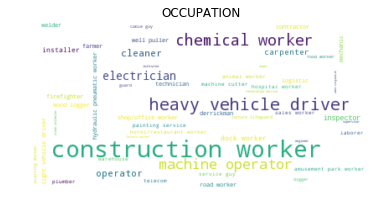

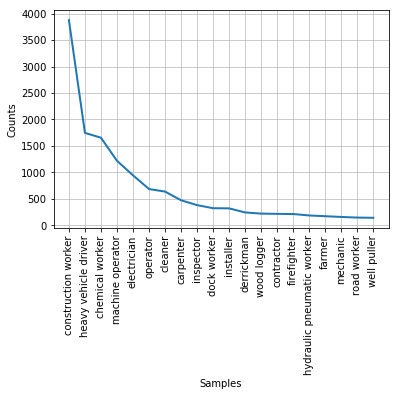

In [353]:
combine=[]
track=0
for key,value in occupation_dict.items():
    #print(key)
    #print(count[track])
    for i in range (0,count[track]-1):
        combine.append(key)
    track=track+1

Occupation_dist = FreqDist(combine)
create_wordcloud(Occupation_dist,"OCCUPATION")
Occupation_distplot=Occupation_dist.plot(20)

In [354]:
from pandas import ExcelWriter
df1 = pd.DataFrame({'Index':news['Index']})
df2 = pd.DataFrame({'Title':news['Title']})
df3 = pd.DataFrame({'Description':news['Description']})
df4 = pd.DataFrame({'Support1':news['Support1']})
df5 = pd.DataFrame({'Support2':news['Support2']})
df6 = pd.DataFrame({'Occupation':store_occupation_array})

 
writer = ExcelWriter('Osha_added_Occupation.xlsx')
df1.to_excel(writer,'out_title',index=False,startcol=0,header=False)
df2.to_excel(writer,'out_title',index=False,startcol=1,header=False)
df3.to_excel(writer,'out_title',index=False,startcol=2,header=False)
df4.to_excel(writer,'out_title',index=False,startcol=3,header=False)
df5.to_excel(writer,'out_title',index=False,startcol=4,header=False)
df6.to_excel(writer,'out_title',index=False,startcol=5,header=False)
writer.save()